In [9]:
!pip install torchvision matplotlib numpy tensorboard standard-imghdr torchnet scikit-learn opencv-python Levenshtein pycm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 3.9 MB/s eta 0:00:00a 0:00:01


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter
from ImageToStringNet import ImageToStringNet, classes
import pandas as pd
import Levenshtein
import sys
from torch.utils.data import random_split, DataLoader, Subset
from pycm import ConfusionMatrix
import json
import os
import random
from torchvision import transforms


In [15]:
print("Classes: ", len(classes))

class DigitDataset(Dataset):
    def __init__(self, imgs_path, txt_path, transform=None):
        self.imgs_path = imgs_path
        self.images = np.loadtxt(txt_path, dtype=str, delimiter='\t', comments=[])
        self.transform = transform
        self.targets = [classes.index(c) for _, c, _, _ in self.images]
        self.targets = torch.LongTensor(self.targets)
        
        self.data = [Image.open(f'{self.imgs_path}/{i}').convert('L') for i, _, _, _ in self.images]
        self.data = [self.transform(i) for i in self.data]
        self.data = torch.stack(self.data, dim=0)

    def __getitem__(self, index):
        _, _, t, b = self.images[index]

        # Image Tensor, Label, Top Margin (%), Bottom Margin (%)
        return self.data[index], self.targets[index], np.float32(t), np.float32(b)

    def __len__(self):
        return len(self.images)

Classes:  96


In [16]:
batch_size = 256
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [41]:
# ---- impostazioni ----
dataset_dir = "../dataset/digit_dataset"
train_txt   = os.path.join(dataset_dir, "train.txt")
test_txt    = os.path.join(dataset_dir, "test.txt")

with open(train_txt, 'r') as f:
    lines = f.read().splitlines()

font_to_indices = {}
for idx, line in enumerate(lines):
    font_name = line.split()[0].split('/')[0]
    font_to_indices.setdefault(font_name, []).append(idx)

# ---- 2) split 80/20 sui font ----
random.seed(1234)
all_fonts = list(font_to_indices.keys())
random.shuffle(all_fonts)

n_train_fonts = int(0.8 * len(all_fonts))
train_fonts = set(all_fonts[:n_train_fonts])
val_fonts   = set(all_fonts[n_train_fonts:])

train_idxs = []
val_idxs   = []
for font, idx_list in font_to_indices.items():
    if font in train_fonts:
        train_idxs.extend(idx_list)
    else:
        val_idxs.extend(idx_list)

In [42]:
trainset = DigitDataset(imgs_path=dataset_dir,
                        txt_path=train_txt,
                        transform=transforms.ToTensor())
testset  = DigitDataset(imgs_path=dataset_dir,
                        txt_path=test_txt,
                        transform=transforms.ToTensor())

train_subset = Subset(trainset, train_idxs)
val_subset   = Subset(trainset, val_idxs)


trainloader = torch.utils.data.DataLoader(train_subset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

In [18]:
net = ImageToStringNet(dropout_rate=0.5)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
dataiter = iter(trainloader)
next(dataiter)[0].shape

torch.Size([256, 1, 28, 28])

In [21]:
writer = SummaryWriter(f'runs/demo')

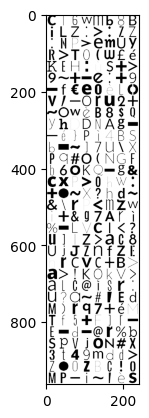

In [22]:
# get some random training images
dataiter = iter(trainloader)
images, labels, t, b = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_img-to-str_images', img_grid)

In [23]:
writer.add_graph(net, (images, t, b))
writer.close()

In [24]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images)
writer.close()

Images shape:  torch.Size([100, 1, 28, 28])
Labels shape:  torch.Size([100])


In [26]:
# helper functions

def images_to_probs(net, images, top_margin, bottom_margin):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images, top_margin, bottom_margin)
    # convert output probabilities to predicted class

    output = output.cpu()

    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels, top_margin, bottom_margin):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images, top_margin, bottom_margin)
    # plot the images in the batch, along with predicted and true labels

    images = images.cpu()

    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [27]:
if torch.xpu.is_available():
    net = net.xpu()

In [28]:
class AverageValueMeter():
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.sum = 0
        self.num = 0
    
    def add(self, value, num):
        self.sum += value * num
        self.num += num
    
    def value(self):
        try:
            return self.sum / self.num
        except:
            return None

In [29]:
loss_meter = AverageValueMeter()
accuracy_meter = AverageValueMeter()

epochs = 25

loader = {
    'train': trainloader,
    'val': valloader,
    'test': testloader
}

In [30]:
with open('validation_parameters.json', 'r') as f:
    configurations = json.load(f)

configurations[:5]

[{'learning_rate': 0.01, 'dropout': 0.2, 'momentum': 0.9},
 {'learning_rate': 0.005, 'dropout': 0.3, 'momentum': 0.5},
 {'learning_rate': 0.001, 'dropout': 0.4, 'momentum': 0.0},
 {'learning_rate': 0.0005, 'dropout': 0.5, 'momentum': 0.9},
 {'learning_rate': 0.0001, 'dropout': 0.3, 'momentum': 0.5}]

In [44]:
results = []

for conf in configurations[:1]:
    net = ImageToStringNet(dropout_rate=conf['dropout'])
    optimizer = optim.SGD(net.parameters(), lr=conf['learning_rate'], momentum=conf['momentum'])

    run_name = f"lr{conf['learning_rate']}_drop{conf['dropout']}_momentum{conf['momentum']}"
    writer = SummaryWriter(f'runs/exp4_{run_name}')
    print('=============================================================')
    print("CONFIGURATION: ", conf)

    final_metrics = {"train": {"loss": 0.0, "accuracy": 0.0},
                     "val": {"loss": 0.0, "accuracy": 0.0}}

    for epoch in range(epochs):
        global_step = 0
        print(f'\nEpoch {epoch + 1}')
        for mode in ["train", "val"]:
            loss_meter.reset()
            accuracy_meter.reset()
            for i, data in enumerate(loader[mode]):
                global_step += batch_size
                with torch.set_grad_enabled(mode == "train"):
                    inputs, labels, t, b = data
                    if torch.xpu.is_available():
                        inputs, labels, t, b = inputs.xpu(), labels.xpu(), t.xpu(), b.xpu()

                    outputs = net(inputs, t, b)
                    loss = criterion(outputs, labels)

                    if mode == "train":
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()

                    loss_meter.add(loss.item(), inputs.size(0))
                    accuracy_meter.add(accuracy_score(labels.cpu(), outputs.cpu().max(1)[1]), inputs.size(0))

                    if i % 10 == 9:
                        writer.add_scalar(f'loss/{mode}', loss_meter.value(), global_step)
                        writer.add_scalar(f'accuracy/{mode}', accuracy_meter.value(), global_step)

            # Salva le metriche finali dell'epoca per ogni modalità
            final_metrics[mode]["loss"] = loss_meter.value()
            final_metrics[mode]["accuracy"] = accuracy_meter.value()

            print(f'\t[{mode}]\tLoss: {loss_meter.value():.4f}, Accuracy: {accuracy_meter.value():.4f}')

        writer.add_figure('predictions vs. actuals',
                          plot_classes_preds(net, inputs, labels, t, b),
                          global_step)
        
    weights_name = f'{run_name}.pth'
    torch.save(net.state_dict(), f'./weights/{weights_name}')

    results.append({
        "learning_rate": conf["learning_rate"],
        "dropout": conf["dropout"],
        "momentum": conf["momentum"],
        "train_loss": final_metrics["train"]["loss"],
        "train_accuracy": final_metrics["train"]["accuracy"],
        "val_loss": final_metrics["val"]["loss"],
        "val_accuracy": final_metrics["val"]["accuracy"],
        "weights_name": weights_name
    })

    print('=============================================================')

CONFIGURATION:  {'learning_rate': 0.01, 'dropout': 0.2, 'momentum': 0.9}

Epoch 1


	[train]	Loss: 3.0076, Accuracy: 0.2949
	[val]	Loss: 0.9048, Accuracy: 0.7225

Epoch 2
	[train]	Loss: 0.6722, Accuracy: 0.7853
	[val]	Loss: 0.5065, Accuracy: 0.8342

Epoch 3
	[train]	Loss: 0.4481, Accuracy: 0.8386
	[val]	Loss: 0.4072, Accuracy: 0.8491

Epoch 4
	[train]	Loss: 0.3529, Accuracy: 0.8633
	[val]	Loss: 0.3282, Accuracy: 0.8682

Epoch 5
	[train]	Loss: 0.3068, Accuracy: 0.8774
	[val]	Loss: 0.2781, Accuracy: 0.8880

Epoch 6
	[train]	Loss: 0.2773, Accuracy: 0.8863
	[val]	Loss: 0.2564, Accuracy: 0.8903

Epoch 7
	[train]	Loss: 0.2590, Accuracy: 0.8917
	[val]	Loss: 0.2567, Accuracy: 0.8937

Epoch 8
	[train]	Loss: 0.2458, Accuracy: 0.8960
	[val]	Loss: 0.2157, Accuracy: 0.9074

Epoch 9
	[train]	Loss: 0.2321, Accuracy: 0.9006
	[val]	Loss: 0.2347, Accuracy: 0.9015

Epoch 10
	[train]	Loss: 0.2213, Accuracy: 0.9039
	[val]	Loss: 0.2127, Accuracy: 0.9076

Epoch 11
	[train]	Loss: 0.2150, Accuracy: 0.9066
	[val]	Loss: 0.2033, Accuracy: 0.9082

Epoch 12
	[train]	Loss: 0.2050, Accuracy: 0.9104


In [26]:
df = pd.DataFrame(results)
df.to_csv("../docs/assets/experimental_results.csv", index=False)

# Evaluation

confusion matrix

In [ ]:
digit_dataset = np.loadtxt('../dataset/digit_dataset/test.txt', dtype=str, delimiter='\t', comments=[])
first_column = digit_dataset[:, 0]
unique_values, unique_indices = np.unique(first_column, return_index=True)
digit_dataset = digit_dataset[unique_indices]

ground_truth = []
results = []
classes += 'ERROR'

for i, data in enumerate(digit_dataset):
    img_path = f'../dataset/digit_dataset/{data[0]}'
    img = Image.open(img_path)
    label = data[1]
    try:
        _, output = process_image(img)
        if output is None or output not in classes:
            output = 'ERROR'
        print(f"[{i}/{len(digit_dataset)}][{data[0].split('/')[0]}]: {label} -> {output}")
    except Exception as e:
        print(f"[{i}/{len(digit_dataset)}][{data[0].split('/')[0]}]: {label} -> {e}")
        output = 'ERROR'
    
    ground_truth.append(label)
    results.append(output)

/home/kevin/Documents/uni/3anno/2_semestre/MACHINE LEARNING/project/university-ml-imgtostr/src/../core/ImageToStringClassifier.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

[0/1410][PTS55F]: ! -> !
[1/1410][PTS55F]: # -> #
[2/1410][PTS55F]: $ -> $
[3/1410][PTS55F]: % -> %
[4/1410][PTS55F]: & -> &
[5/1410][PTS55F]: ' -> '
[6/1410][PTS55F]: ( -> (
[7/1410][PTS55F]: ) -> )
[8/1410][PTS55F]: + -> +
[9/1410][PTS55F]: , -> ,
[10/1410][PTS55F]: - -> -
[11/1410][PTS55F]: 0 -> 'NoneType' object is not subscriptable
[12/1410][PTS55F]: 1 -> 1
[13/1410][PTS55F]: 2 -> 2
[14/1410][PTS55F]: 3 -> 3
[15/1410][PTS55F]: 4 -> 4
[16/1410][PTS55F]: 5 -> 5
[17/1410][PTS55F]: 6 -> 6
[18/1410][PTS55F]: 7 -> 7
[19/1410][PTS55F]: 8 -> 8
[20/1410][PTS55F]: 9 -> 9
[21/1410][PTS55F]: : -> :
[22/1410][PTS55F]: ; -> ;
[23/1410][PTS55F]: < -> <
[24/1410][PTS55F]: > -> >
[25/1410][PTS55F]: ? -> ?
[26/1410][PTS55F]: @ -> @
[27/1410][PTS55F]: A -> A
[28/1410][PTS55F]: B -> B
[29/1410][PTS55F]: C -> 'NoneType' object is not subscriptable
[30/1410][PTS55F]: D -> D
[31/1410][PTS55F]: E -> E
[32/1410][PTS55F]: F -> F
[33/1410][PTS55F]: G -> G
[34/1410][PTS55F]: H -> H
[35/1410][PTS55F]: I -> I


In [ ]:
cm = ConfusionMatrix(actual_vector=ground_truth, predict_vector=results)

cm.save_html("../docs/assets/confusion_matrix_report", color=(100, 150, 255))  # Blu chiaro